# Neural Net

In [27]:
def intitializeAgent():
    
    model = Sequential()
    
    model.add(Dense(256,activation='relu',input_shape=(INPUT_SIZE,)))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(OUTPUT_SIZE,activation='linear'))
    
    model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    
    return model

In [28]:
def getPrediction(env,agent):
    env = env.reshape(INPUT_SIZE,1).reshape(1,-1)
    return agent.predict(env)[0]

In [29]:
def getAction(output,invalidActions):
    rand = np.random.rand()
    output[invalidActions] = np.min(output) - 0.1
    
    if rand < EPSILON_RATE ** iteration:
        action = np.random.randint(4)
        while action in invalidActions:
            action = np.random.randint(4)
        return action
    else:
        return np.argmax(output)

In [30]:
def getGreedyAction(output,invalidActions):
    output[invalidActions] = np.min(output) - 0.1
    return np.argmax(output)

In [31]:
def train(initialStateMemory,actionMemory,rewardMemory,finalStateMemory,model,epochs):
    
    if memCount < MAX_MEM_SIZE:
        sample = np.random.choice(memCount, SAMPLE_SIZE)
    else:
        sample = np.random.choice(MAX_MEM_SIZE, SAMPLE_SIZE)
    batchSize = sample.shape[0] // BATCH_SIZE
    
    if batchSize == 0:
        batchSize = 1
                
    targetQs = getTargetQs(initialStateMemory[sample],
                            actionMemory[sample],
                            rewardMemory[sample],
                            finalStateMemory[sample],
                            model)
        
    print("Training Model...")
    model.fit(initialStateMemory[sample],targetQs,batch_size = batchSize, epochs = epochs, verbose = 0)

# Replay Memory

In [32]:
def addMemory(initialState, action, reward, finalState, memCount, MAX_MEM_SIZE):
    if memCount < MAX_MEM_SIZE:
        initialStateMemory[memCount] = initialState.reshape(INPUT_SIZE)
        actionMemory[memCount] = action
        rewardMemory[memCount] = reward
        finalStateMemory[memCount] = finalState.reshape(INPUT_SIZE)
    else:
        rand = np.random.randint(MAX_MEM_SIZE)
        initialStateMemory[rand] = initialState.reshape(INPUT_SIZE)
        actionMemory[rand] = action
        rewardMemory[rand] = reward
        finalStateMemory[rand] = finalState.reshape(INPUT_SIZE)
        
    memCount += 1
    
    return initialStateMemory,actionMemory,rewardMemory,finalStateMemory,memCount

In [33]:
def getTargetQs(states0, actions0, rewards1, states1, agent):
    DISCOUNT_FACTOR = 0.99
    targetQs = np.zeros((len(states0),OUTPUT_SIZE))
    
    for i in range(len(states0)):
        targetQs[i] = getPrediction(states0[i],agent)
        targetQs[i][int(actions0[i])] = rewards1[i] + DISCOUNT_FACTOR * np.max(getPrediction(states1[i],agent))
    return targetQs

# Game Logic

In [34]:
def initializeEnv():
    env = np.zeros((BOARD_LENGTH,BOARD_LENGTH))

    for i in range(2):
        addValue(env)
            
    return env

In [35]:
def addValue(env):
#     rand = np.random.rand()
#     if rand > 0.1:
#         value = 2
#     else:
#         value = 4
    value = 2
        
    coordinate1 = random.sample(range(0,BOARD_LENGTH),1)
    coordinate2 = random.sample(range(0,BOARD_LENGTH),1)
        
    if env[coordinate1,coordinate2] != 0:
        getNewCoordinate(env,value)
    else:
        env[coordinate1,coordinate2] = value
        
    return env

In [36]:
def getNewCoordinate(env,value):
    
    coordinate1 = random.sample(range(0,BOARD_LENGTH),1)
    coordinate2 = random.sample(range(0,BOARD_LENGTH),1)
    
    while env[coordinate1,coordinate2] != 0:
        coordinate1 = random.sample(range(0,BOARD_LENGTH),1)
        coordinate2 = random.sample(range(0,BOARD_LENGTH),1)
    
    env[coordinate1,coordinate2] = value

In [37]:
def step(env,action,score):
    
    if action == 0:
        env, score, validAction = actionUp(env,score)
    if action == 1:
        env, score, validAction = actionDown(env,score)
    if action == 2:
        env, score, validAction = actionLeft(env,score)
    if action == 3:
        env, score, validAction = actionRight(env,score)
    
    return env, score, validAction

In [38]:
def actionUp(env,score):
    validAction = False
    
    for i in range(BOARD_LENGTH):
        for j in range(BOARD_LENGTH):
            row = i
            while env[row][j] != 0 and row != 0:
                if env[row - 1][j] != 0:
                    if env[row - 1][j] == env[row][j]:
                        env[row - 1][j] *= 2
                        env[row][j] = 0
                        score += env[row - 1][j]
                        validAction = True
                    break
                temp = env[row][j]
                env[row-1][j] = temp
                env[row][j] = 0
                row -= 1
                validAction = True
    return env, score, validAction

In [39]:
def actionDown(env,score):
    validAction = False
    
    for i in range(3,-1,-1):
        for j in range(BOARD_LENGTH):
            row = i
            while env[row][j] != 0 and row != 3:
                if env[row + 1][j] != 0:
                    if env[row + 1][j] == env[row][j]:
                        env[row + 1][j] *= 2
                        env[row][j] = 0
                        score += env[row + 1][j]
                        validAction = True
                    break
                temp = env[row][j]
                env[row + 1][j] = temp
                env[row][j] = 0
                row += 1
                validAction = True
    return env, score, validAction

In [40]:
def actionLeft(env,score):
    validAction = False
    env = env.T
    
    for i in range(BOARD_LENGTH):
        for j in range(BOARD_LENGTH):
            row = i
            while env[row][j] != 0 and row != 0:
                if env[row - 1][j] != 0:
                    if env[row - 1][j] == env[row][j]:
                        env[row - 1][j] *= 2
                        env[row][j] = 0
                        score += env[row - 1][j]
                        validAction = True
                    break
                temp = env[row][j]
                env[row-1][j] = temp
                env[row][j] = 0
                row -= 1
                validAction = True
    env = env.T
    return env, score, validAction

In [41]:
def actionRight(env,score):
    validAction = False
    env = env.T
    
    for i in range(3,-1,-1):
        for j in range(BOARD_LENGTH):
            row = i
            while env[row][j] != 0 and row != 3:
                if env[row + 1][j] != 0:
                    if env[row + 1][j] == env[row][j]:
                        env[row + 1][j] *= 2
                        env[row][j] = 0
                        score += env[row + 1][j]
                        validAction = True
                    break
                temp = env[row][j]
                env[row + 1][j] = temp
                env[row][j] = 0
                row += 1
                validAction = True
    env = env.T
    return env, score, validAction

In [42]:
def getAvailableAction(env):
    tempEnv = np.copy(env)
    available = False
    
    for i in range(tempEnv.shape[0]):
        for j in range(tempEnv.shape[0] - 1):
            if tempEnv[i][j] == tempEnv[i][j+1]:
                available = True
                
                
    tempEnv = tempEnv.T
    for i in range(tempEnv.shape[0]):
        for j in range(tempEnv.shape[0] - 1):
            if tempEnv[i][j] == tempEnv[i][j+1]:
                available = True
                break
    
    return available

In [43]:
def run(env,agent,memCount,testFlag,score = 0):
    
    gameOver = False
    while gameOver == False:
        invalidActions = []
        validAction = False
        while validAction == False:
            
            if not testFlag:
                previousEnv = np.copy(env)
                previousScore = np.copy(score)
            
            output = getPrediction(env,agent)
            if testFlag: 
                action = getGreedyAction(output,invalidActions) 
            else: 
                action = getAction(output,invalidActions)
            invalidActions.append(action)
            env, score, validAction = step(env, action, score)
        
        if not testFlag:
            initialStateMemory,actionMemory,rewardMemory,finalStateMemory,memCount = addMemory(previousEnv, action, score - previousScore, env, memCount, MAX_MEM_SIZE)

        env = addValue(env)
        
        if np.sum(env == 0) == 0:
            gameOver = not getAvailableAction(env)
    
    if not testFlag:
        return score,initialStateMemory,actionMemory,rewardMemory,finalStateMemory,memCount
    else: 
        return score

# Main Output Functions

In [44]:
def printIter():
    print("\n === === === Iteration",iteration,"of",ITERATIONS,'=== === ===\n')

In [45]:
def printStats(timeLog,iteration,ITERATIONS,memCount,scoreLog,greedyScoreLog,EPISODES,TESTS):
    print("\nEstimated time remaining: ", format(np.mean(timeLog) * (ITERATIONS - iteration) / 60,'.2f')," Minutes\n")
    print("Memories Elapsed: ",memCount)
    print("Current Epsilon: ",format(EPSILON_RATE ** iteration,'.4f'))
    print("Ave Score for Epoch: ", format(np.mean(scoreLog[len(scoreLog) - EPISODES : len(scoreLog)-1]) ,'.2f'))
    print("Ave Greedy Score for Epoch: ", format(np.mean(greedyScoreLog[len(greedyScoreLog) - TESTS : len(greedyScoreLog)-1]) ,'.2f'))

In [46]:
def printTrainInfo():
    print("Maximum memory size:",MAX_MEM_SIZE)
    print("Sample size for training:",SAMPLE_SIZE)
    print("Batch size from sample:",BATCH_SIZE)
    print("Epslon Rate:",format(EPSILON_RATE,'.4f'))

# Main

In [47]:
import numpy as np 
import matplotlib.pyplot as plt
import random
import time
import sys

from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout

In [48]:
BOARD_LENGTH = 4
INPUT_SIZE = 16
OUTPUT_SIZE = BOARD_LENGTH

memCount = 0
MAX_MEM_SIZE = 100_000
SAMPLE_SIZE = MAX_MEM_SIZE // 200
BATCH_SIZE = SAMPLE_SIZE // 100
initialStateMemory = np.zeros((MAX_MEM_SIZE,INPUT_SIZE))
actionMemory = np.zeros(MAX_MEM_SIZE)
rewardMemory = np.zeros(MAX_MEM_SIZE)
finalStateMemory = np.zeros((MAX_MEM_SIZE,INPUT_SIZE))


gameScoreLog = []
greedyScoreLog = []
agent = intitializeAgent()

In [49]:
ITERATIONS = 100
EPISODES = 100
TESTS = EPISODES // 5
EPOCHS = 4
MIN_EPSILON = 0.05
EPSILON_RATE = MIN_EPSILON ** (1./ITERATIONS)

In [50]:
startTime = time.time()
timeLog = []
    
printTrainInfo()

for iteration in range(ITERATIONS):
    printIter()
    iterationStart = time.time()
    
    for i in range(EPISODES):

        score,initialStateMemory,actionMemory,rewardMemory,finalStateMemory,memCount = run(initializeEnv(),agent,memCount,False)
        gameScoreLog.append(score)
    
    for i in range(TESTS):
        
        score = run(initializeEnv(),agent,memCount,True)
        greedyScoreLog.append(score)
        
    train(initialStateMemory,actionMemory,rewardMemory,finalStateMemory,agent,EPOCHS)
    timeLog.append(time.time() - iterationStart)

    printStats(timeLog,iteration,ITERATIONS,memCount,gameScoreLog,greedyScoreLog,EPISODES,TESTS)
    
    if EPISODES != 25:
        startTime = time.time()
        timeLog = []
        gameScoreLog = []
        greedyScoreLog = []
    
    EPISODES = 25
    TESTS = EPISODES // 5

Maximum memory size: 100000
Sample size for training: 500
Batch size from sample: 5
Epslon Rate: 0.9705

 === === === Iteration 0 of 100 === === ===

Training Model...

Estimated time remaining:  20.04  Minutes

Memories Elapsed:  13210
Current Epsilon:  1.0000
Ave Score for Epoch:  1185.37
Ave Greedy Score for Epoch:  2382.95

 === === === Iteration 1 of 100 === === ===

Training Model...

Estimated time remaining:  5.27  Minutes

Memories Elapsed:  16631
Current Epsilon:  0.9705
Ave Score for Epoch:  1204.00
Ave Greedy Score for Epoch:  1720.00

 === === === Iteration 2 of 100 === === ===

Training Model...

Estimated time remaining:  5.14  Minutes

Memories Elapsed:  20153
Current Epsilon:  0.9418
Ave Score for Epoch:  1271.00
Ave Greedy Score for Epoch:  1320.00

 === === === Iteration 3 of 100 === === ===

Training Model...

Estimated time remaining:  5.00  Minutes

Memories Elapsed:  23361
Current Epsilon:  0.9140
Ave Score for Epoch:  1132.33
Ave Greedy Score for Epoch:  1578.00

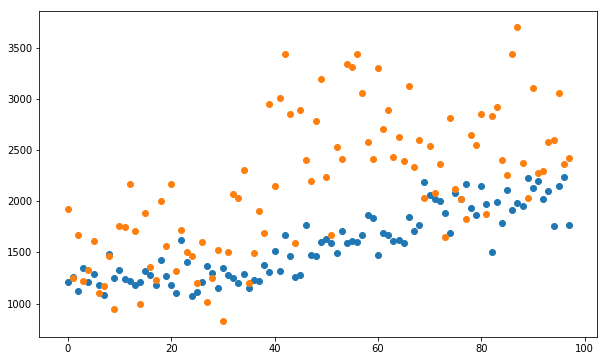

In [51]:
def getMovingAve(movingAveSize, scores):
    movingAve = []
    
    for i in range(len(scores) // movingAveSize):
        if (i + 1) * movingAveSize < len(scores):
            movingAve.append(np.mean(scores[i*movingAveSize:(i+1)*movingAveSize]))
    return movingAve


def mapScores():
    movingAveSize = 5
    
    movingAveA = getMovingAve(movingAveSize * 5, gameScoreLog)
    movingAveB = getMovingAve(movingAveSize, greedyScoreLog)
    
    plt.figure(figsize=(10,6))
    plt.scatter(np.arange(len(movingAveA)),movingAveA)
    plt.scatter(np.arange(len(movingAveB)),movingAveB)
    
mapScores()

In [52]:
def testAgent():
    games = 500
    
    scores = np.zeros(games)
    
    for i in range(games):
        scores[i] = (run(initializeEnv(),agent,memCount,True))
    
    print("Average Score: ", np.mean(scores))
    print("Std Deviation: ", format(np.std(scores),'.2f'))
    print("Time elapsed:  ", format(time.time() - startTime, '.2f'))
    

testAgent()

Average Score:  2539.712
Std Deviation:  1213.13
Time elapsed:   472.13
